In [ ]:
from IPython.display import clear_output

!pip3 install lightfm
!pip install gspread google-auth
!pip install optuna
!pip install gower
clear_output()

In [ ]:
import numpy as np
import pandas as pd
from lightfm import LightFM
from lightfm.data import Dataset
from scipy import sparse

import pickle
import random
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from google.colab import files
import time

from google.colab import drive
from google.colab import auth
from google.auth import default
import gspread

# optuna

In [ ]:
import optuna
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, recall_at_k

def objective(trial):

    train, val = random_train_test_split(sparse.csr_matrix(train_interactions.values), test_percentage=0.25, random_state=42)

    param = {
        'no_components': trial.suggest_int("no_components", 5, 64),
        "learning_schedule": trial.suggest_categorical("learning_schedule", ["adagrad", "adadelta"]),
        "loss":  trial.suggest_categorical("loss", ["bpr", "warp", "warp-kos"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1),
        "item_alpha": trial.suggest_float("item_alpha", 1e-10, 1e-06, log=True),
        "user_alpha": trial.suggest_float("user_alpha", 1e-10, 1e-06, log=True),
        "max_sampled": trial.suggest_int("max_sampled", 5, 15),
    }
    epochs = trial.suggest_int("epochs", 20, 50)

    model = LightFM(**param, random_state=42)
    model.fit(train,
              epochs = epochs,
              verbose=True)

    val_precision = precision_at_k(model,
                                   val,
                                   train_interactions=train,
                                   k=10).mean()
    return val_precision

study = optuna.create_study(direction="maximize")



In [ ]:
study.enqueue_trial(params={"no_components":10,
                            					"learning_schedule":'adagrad',
                            					"loss":'warp',
                            					"learning_rate":0.05,
                            					"item_alpha":1e-10,
                            					"user_alpha":1e-10,
                            					"max_sampled":10,
                            					"epochs":30})

study.optimize(objective, n_trials=50)

best_params = study.best_params
for k, v in best_params.items():
    print(k,":",v)

In [ ]:
optuna.importance.get_param_importances(study)

# тест гипотезы 1 - о полезности груп предпочтений

тут надо просто сделать первый обычный цикл обучения но полочить в трейн сразу 20 оценок из итеративного этапа, но не с групповыми оценками а с первичными

In [ ]:
# задачем название колонки в которой лежит вес пользователей для агрегации
INDIVIDUAL_COEF = 'final_coef'
COMPONENTS = 10
IDENTITY = True

In [ ]:
# открываем первичные оценки с итеративного этапа
c1 = pd.read_excel('intrc_it_111.xlsx').rename(columns={'Unnamed: 0': 'user'})
c2 = pd.read_excel('intrc_it_222.xlsx').rename(columns={'Unnamed: 0': 'user'})
c3 = pd.read_excel('intrc_it_333.xlsx').rename(columns={'Unnamed: 0': 'user'})
c4 = pd.read_excel('intrc_it_444.xlsx').rename(columns={'Unnamed: 0': 'user'})
c5 = pd.read_excel('intrc_it_555.xlsx').rename(columns={'Unnamed: 0': 'user'})

test_ind_interactions = pd.concat([c1,
                                   c2.drop('user', axis=1),
                                   c3.drop('user', axis=1),
                                   c4.drop('user', axis=1),
                                   c5.drop('user', axis=1)], axis=1).dropna(axis=1, how='all')
test_ind_interactions

,user,11,119,125,136,21,122,152,173,18,...,86,197,28,68,78,157,1,118,132,156
0,Ксю,-1,-1,1,1,1,-1,-1,1,-1,...,1,1,1,-1,1,-1,-1,1,-1,-1
1,Аня,-1,-1,1,1,1,-1,-1,-1,-1,...,-1,-1,-1,-1,1,-1,-1,1,1,-1
2,Лиза,1,-1,1,1,1,1,1,1,-1,...,1,1,-1,-1,1,-1,-1,1,-1,-1
3,Катя,-1,-1,1,1,1,1,1,1,-1,...,-1,-1,-1,-1,1,1,-1,1,-1,-1
4,Ира,-1,-1,1,1,1,-1,1,1,-1,...,-1,-1,-1,-1,1,-1,-1,1,-1,-1
5,Окси,-1,-1,1,1,1,-1,1,1,-1,...,-1,-1,-1,-1,1,-1,-1,1,-1,-1


In [ ]:
# каталог мероприятий в сыром виде
event_data = pd.read_excel('events.xlsx')
# данные о пои, юзерах и трен взаимодействиях
train_event_features = pd.read_csv('encoded_items_train.csv')
test_event_features = pd.read_csv('encoded_items_test.csv')
user_features_data = pd.read_csv('user_traits.csv')
train_interactions = pd.read_csv('interactions_train.csv')

# !!!!! добавляем в тренировку 20 первичных тест оценок
train_interactions = train_interactions.merge(test_ind_interactions, how='left', on='user')
train_interactions = train_interactions.set_index('user')
print('train_interactions', train_interactions.shape) # дб 6 на 146


train_interactions.columns = train_interactions.columns.astype(str)
# делаем 1 из дизлайка и 5 из лайка
train_interactions = train_interactions.replace(1, 5).replace(-1, 1)


train_event_features = train_event_features.rename(columns={'id': 'item_id'})
train_event_features['item_id'] = train_event_features['item_id'].astype(str)
test_event_features = test_event_features.rename(columns={'id': 'item_id'})
test_event_features['item_id'] = test_event_features['item_id'].astype(str)

# добавляем в трейн фичи фичи добавленных 20ти тестовых
train_event_features = pd.concat([train_event_features, test_event_features[test_event_features.item_id.isin(train_interactions.columns)]])
print('train_event_features', train_event_features.shape) # дб 146 на 49
# удаляем из тестовой выборки эти 20 штук
test_event_features = test_event_features[~test_event_features.item_id.isin(train_interactions.columns)]
print('test_event_features', test_event_features.shape) # дб 56 на 49

user_features_data = user_features_data.rename(columns={'name': 'user_id'})
user_features_data = user_features_data.drop(
    list(set([
        'mood',
        'Соперничество',
        'Сотрудничество',
        'Компромисс',
        'Избегание',
        'Приспособление',
        'conflict_coef',
        'Extraversion',
        'Agreableness',
        'Conscientiousness',
        'Neuroticism',
        'Openness',
        'character_coef',
        'final_coef',
        'final_coef_scaled',
    ]) - {INDIVIDUAL_COEF}),
    axis=1,
)

train_interactions (6, 146)
train_event_features (146, 49)
test_event_features (56, 49)


In [ ]:
scaler = MinMaxScaler()

user_features_data[['age', 'income']] = scaler.fit_transform(user_features_data[['age', 'income']])
user_features_data

,user_id,age,income,final_coef,residence_moscow,residence_nnovgorod,fulltime_work,student,unemployed
0,Окси,1.0,1.0,0.760000,1,0,1,0,0
1,Катя,0.5,0.0,1.216154,0,1,0,1,1
2,Ксю,0.5,1.0,0.603750,1,0,1,0,0
3,Лиза,0.0,0.5,1.014444,0,1,1,1,0
4,Ира,1.0,0.5,1.700000,0,1,1,1,0
5,Аня,0.5,0.5,1.666000,0,1,1,0,0


In [ ]:
spreadsheet = gc.open('Результаты TKI')
worksheet = spreadsheet.get_worksheet(6)
data = worksheet.get_all_values()
headers = data.pop(0)

df = pd.DataFrame(data, columns=headers)
user_features_data = user_features_data.drop('final_coef', axis=1)\
                                       .merge(
                                           df[['', 'final_coef']].rename(columns={'':'user_id'}),
                                           how='left',
                                           on='user_id'
                                           )
user_features_data.final_coef = user_features_data.final_coef.str.replace(',', '.').astype(float)
user_features_data

'\n"0,403" ксю\n"1,232" аня\n"0,733" лиза\n"1,229" катя\n"1,452" ира\n"0,500" окси\n'

In [ ]:
spreadsheet = gc.open('Онбординг (Ответы)')

worksheet = spreadsheet.get_worksheet(0)
data = worksheet.get_all_values()
headers = data.pop(0)

moods = pd.DataFrame(data, columns=headers)
user_features_data = user_features_data.merge(
                        moods[['Имя', 'Настроение']].rename(
                            columns={'Имя':'user_id',
                                     'Настроение': 'moods'}),
                        how='left',
                        on='user_id'
                        )
user_features_data.moods = user_features_data.moods.apply(lambda x: [str(m).strip() for m in x.split(',')])
user_features_data

In [ ]:
dataset = Dataset(user_identity_features=IDENTITY, item_identity_features=IDENTITY)

dataset.fit(
    users=user_features_data['user_id'],
    items=pd.concat([train_event_features, test_event_features], axis=0)['item_id'],
    user_features=user_features_data.drop(
        ['user_id', INDIVIDUAL_COEF, 'moods'], axis=1
        ).columns.tolist(),
    item_features=train_event_features.drop(
        ['item_id'], axis=1
    ).columns.tolist(),  # трейн потому что колонки одинаковые
)

In [ ]:
user_features = dataset.build_user_features(
    (
        (x['user_id'], {f: x[f] for f in user_features_data.drop([INDIVIDUAL_COEF, 'moods'], axis=1).columns if f != 'user_id'})
        for _, x in user_features_data.drop([INDIVIDUAL_COEF, 'moods'], axis=1).iterrows()
    ), normalize=False
)


train_item_features = dataset.build_item_features(
    (
        (x['item_id'], {f: x[f] for f in train_event_features.columns if f != 'item_id'})
        for _, x in train_event_features.iterrows()
    ), normalize=False
)

# создаем разреженную матрицу взаимодействий
interaction_matrix = sparse.csr_matrix(train_interactions.values)

In [ ]:
model = LightFM(loss='warp',
                learning_schedule='adagrad',
                no_components=COMPONENTS,
                # learning_rate=0.58,
                random_state=42)

model.fit(
    interactions=interaction_matrix,  # train_data
    user_features=user_features,
    item_features=train_item_features,
    epochs=38,
    num_threads=1
)

# сохраняем текущую модель
with open('ind_pref_based_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [ ]:
def get_user_profile(md, ds, user_id, ufm):
    user_internal_id = ds.mapping()[0][user_id]
    return md.get_user_representations(ufm)[1][user_internal_id]


def calculate_mood_weight(moods):
    base_weight = 0
    mood_effect = {
        'support': ['грустное', 'подавленное', 'уставшее', 'ленивое',
                   'апатичное', 'тревожное', 'испуганное'],
        'restrain': ['взволнованное', 'гиперактивное', 'раздраженное',
                     'счастливое'],
        'neutral': ['радостное', 'приподнятое', 'спокойное']
    }

    for mood in moods:
        if mood.lower() in mood_effect['support']:
            base_weight += 0.5
        elif mood.lower() in mood_effect['restrain']:
            base_weight -= 0.5

    return 1 + base_weight / len(moods)

# Агрегация профилей пользователей с учетом весов
def get_user_weight(user_row, col):
    # тут можно усложнить расчет весов?
    # настроения обязательно лежат в юзер фичах в колонке moods в виде списка
    mood_weight = calculate_mood_weight(user_row['moods'])
    return user_row[col] * mood_weight # ** 2


def aggregate_user_profiles(md, ds, ufd, ufm, user_ids, user_weights, k=0):
    group_profile = np.zeros(md.get_user_representations(ufm)[1].shape[1])  # одномерный вектор размера n_components 10
    total_weight = 0
    for user_id in user_ids:
        user_idx = ufd.index[ufd['user_id'] == user_id].tolist()[0]
        user_profile = get_user_profile(md, ds, user_id, ufm)
        user_weight = get_user_weight(ufd.iloc[user_idx], user_weights)
        group_profile += user_profile * user_weight
        total_weight += user_weight

    if total_weight > 0:
      # аргумент k можно использовать для усиления влияния весов
        group_profile /= total_weight - total_weight * k

    return group_profile


# без весов
# def aggregate_user_profiles(md, ds, ufm, user_ids):
#     group_profile = None
#     num_users = len(user_ids)

#     for user_id in user_ids:
#         user_profile = get_user_profile(md, ds, user_id, ufm)
#         if group_profile is None:
#             group_profile = np.zeros_like(user_profile)
#         group_profile += user_profile

#     group_profile /= num_users
#     return group_profile


def get_group_recommendations(md, ds, gp, test_item_features, test_events, ufm, n=10):
    _, _, item_mapping, _ = ds.mapping()
    internal_item_ids = [item_mapping[item_id] for item_id in test_events['item_id']]
    group_features = sparse.csr_matrix(gp.reshape(1, -1))
    scores = md.predict(
        user_ids=np.zeros(
            len(internal_item_ids), dtype=np.int32
        ),  # нули так как в гп у нас только 1 пользователь, его индекс 0
        # вообще тут должны быть внутренние id пользователей которым рекомендовать
        item_ids=np.array(internal_item_ids),  # из чего рекомендуем
        user_features=group_features,
        item_features=test_item_features,
    )
    top_items_indices = np.argsort(-scores)[:n]
    top_n_scores = sorted(scores.tolist(), reverse=True)[:n]
    # print(top_n_scores)
    return test_events.iloc[top_items_indices]['item_id'].tolist()

In [ ]:
user_ids = ['Ксю', 'Аня', 'Лиза', 'Катя', 'Ира', 'Окси']
group_profile = aggregate_user_profiles(
    model, dataset, user_features_data, user_features, user_ids, INDIVIDUAL_COEF, 0
    )

test_item_features = dataset.build_item_features(
    (
        (x['item_id'], {f: x[f] for f in test_event_features.columns if f != 'item_id'})
        for _, x in test_event_features.iterrows()
    ),
    normalize=False,
)

top_n_group_recommendations = get_group_recommendations(
    model, dataset, group_profile, test_item_features, test_event_features, user_features
)

print(top_n_group_recommendations)

event_data['id'] = event_data['id'].astype(str)

display(
    event_data[event_data['id'].isin(top_n_group_recommendations[:7])]
    .set_index('id')
    .reindex(top_n_group_recommendations[:7])
    .reset_index()
)

# random seed для рандома рекомендации
random.seed(43)
event_data[
    event_data.id
    == random.choice(test_event_features[
        ~test_event_features.item_id.isin(top_n_group_recommendations[:7])
        ].item_id)
]

['129', '128', '35', '147', '37', '138', '148', '88', '168', '202']


,id,cat_1,cat_2,name,desc,date,loc,price,link
0,129,"Погулять, Экскурсия","Уличная, Природа, Животные, История",Экотропы. «Захарьинская пойма» в заказнике «До...,Ландшафтный заказник «Долина реки Сходни в Кур...,Даты: -,"Место: 55.907730, 37.386544 (далеко)",Стоимость: бесплатно,Ссылка: -
1,128,"Погулять, Экскурсия","Уличная, Природа, Животные, История",Экотропы. «Природа Алешкинского леса» в Тушинс...,Экскурсия пройдет в Алешкинском лесу на террит...,Даты: -,"Место: 55.864036, 37.418725 (дальше)",Стоимость: бесплатно,Ссылка: ссылка
2,35,Кинопоказ,"Классика, Мультфильмы",Кинопоказ фильма «Мальчик и птица»,Показ от Киноклуба Дом Динамо и его кураторов ...,"Даты: 4 мая, 20:00","Место: ГУМ, Красная площадь, 3, 2 этаж, 1 линия.",Стоимость: бесплатно,Ссылка: по регистрации
3,147,Тусовка,"Танцы, Музыка",NU: HARD HIGHTS в RNDM,Вечеринка тяжелой скоростной электроники и хар...,Даты: 3 мая с 22:00 до 07:00.,"Место: клуб RNDM. Наставнический пер., 13/15, ...",Стоимость: предпродажа от 1000 ₽ по ссылке.,Ссылка: https://t.me/NotUnderground/215
4,37,Тусовка,"Музыка, Танцы",ARMA 16 Years,"У Arma (ex-Mutabor) — день рождения — 16 лет, ...",Даты: 27 - 29 апреля 23:00,"Место: Москва, Шарикоподшипниковская ул., 13, ...",Стоимость: от 3000 р,Ссылка: Билеты.
5,138,Тусовка,"Танцы, Музыка",Дебютная вечеринка команды R-99.,Она откроет серию мечтательно-дарковым звучани...,Даты: 28 апреля,Место: RNDM клуб,Стоимость: 2500 р,Ссылка: Билеты по ссылке.
6,148,Тусовка,"Танцы, Музыка",LOCAL RADIO SHOWCASE в Powerhouse,Шоукейс воронежского электронного онлайн-радио...,Даты: 3 мая с 23:00.,Место: бар Powerhouse Moscow. Гончарная 7/4.,Стоимость: за донейшн (сколько не жалко).,Ссылка: https://t.me/radio_local/302


,id,cat_1,cat_2,name,desc,date,loc,price,link
3,4,Выставка,Живопись,Может ли место помнить?,В арт-пространстве Cube открылось несколько но...,Даты: по 19 мая.,"Место: Москва, Тверская, 3. арт-пространство C...",Стоимость: 400 ₽. Билеты по ссылке.,Ссылка: https://cube.moscow/anna-kanfer-mon-art/


# Визуализация различий

In [ ]:
set1 = test_event_features[test_event_features.item_id.isin(['30', '109', '108', '3', '129'])].reset_index(drop=True)
set2 = test_event_features[test_event_features.item_id.isin(['51', '109', '108', '128', '104'])].reset_index(drop=True)
set3 = test_event_features[test_event_features.item_id.isin(['74', '35', '51', '69', '109'])].reset_index(drop=True)

set4 = test_event_features[test_event_features.item_id.isin(['129', '128', '114', '108', '104', '30', '3', '69', '51', '109', '129', '128'])].reset_index(drop=True)
set5 = test_event_features[test_event_features.item_id.isin(['109', '74', '35', '69', '51', '3', '128', '114', '105', '42', '109', '74'])].reset_index(drop=True)

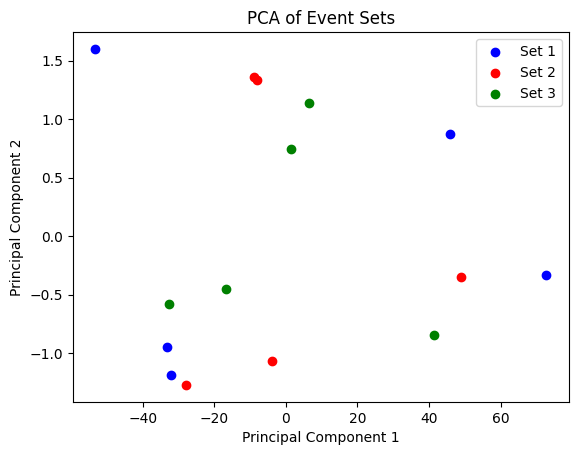

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
set1_pca = pca.fit_transform(set1)
set2_pca = pca.fit_transform(set2)
set3_pca = pca.fit_transform(set3)

plt.scatter(set1_pca[:, 0], set1_pca[:, 1], color='blue', label='Set 1')
plt.scatter(set2_pca[:, 0], set2_pca[:, 1], color='red', label='Set 2')
plt.scatter(set3_pca[:, 0], set3_pca[:, 1], color='green', label='Set 3')
plt.legend()
plt.title('PCA of Event Sets')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
combined_data = pd.concat([set1.assign(source='set1'), set2.assign(source='set2')], ignore_index=True)

# Идентифицируем и удалим дубликаты
combined_data_unique = combined_data.drop_duplicates(subset=set1.columns[1:].tolist(), keep='first')

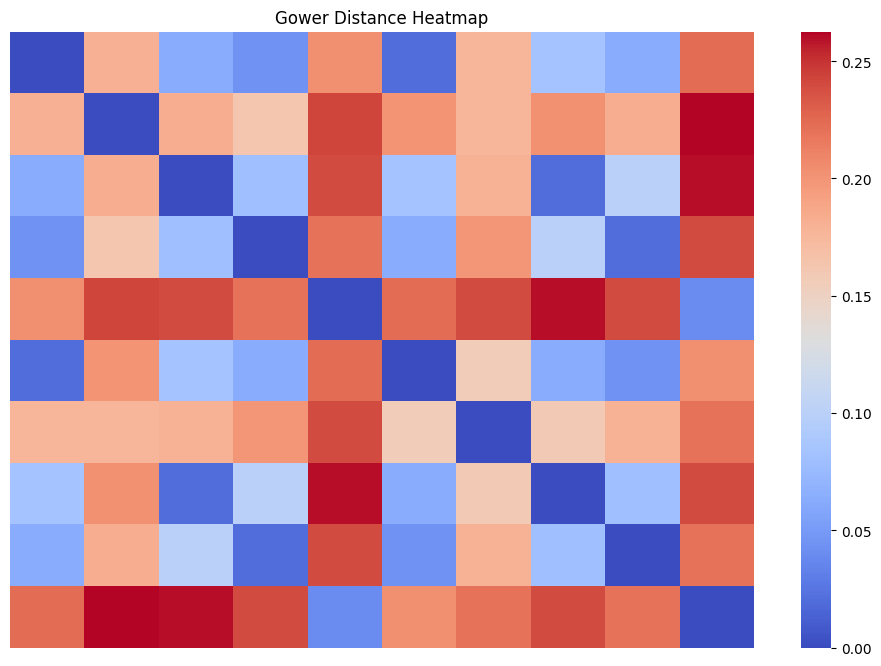

In [ ]:
import seaborn as sns
gower_distances = gower.gower_matrix(combined_data)

# Визуализация
plt.figure(figsize=(12, 8))
sns.heatmap(gower_distances, cmap='coolwarm', xticklabels=False, yticklabels=False)
plt.title('Gower Distance Heatmap')
plt.show()


# Подсчет разнообразия

In [ ]:
# Функция для среднего расстояния внутри набора с использованием Gower's distance
def average_distance_within_set(events):
    distances = gower.gower_matrix(events)
    n = len(events)
    total_distance = 0
    count = 0
    for i in range(n):
        for j in range(i + 1, n):
            total_distance += distances[i, j]
            count += 1
    return total_distance / count if count > 0 else 0

# Функция для среднего расстояния между наборами с использованием Gower's distance
def average_distance_between_sets(set1, set2):
    total_distance = 0
    count = 0
    for i in range(len(set1)):
        for j in range(len(set2)):
            total_distance += gower.gower_matrix(pd.DataFrame([set1.iloc[i]]), pd.DataFrame([set2.iloc[j]]))[0, 0]
            count += 1
    return total_distance / count if count > 0 else 0


within_set1 = average_distance_within_set(set1)
within_set2 = average_distance_within_set(set2)
within_set3 = average_distance_within_set(set3)
within_set4 = average_distance_within_set(set4)
within_set5 = average_distance_within_set(set5)
between_sets = average_distance_between_sets(set1, set3)

print(f"Average distance within set 1: {within_set1}")
print(f"Average distance within set 2: {within_set2}")
print(f"Average distance within set 3: {within_set3}")
print(f"Average distance within set 4: {within_set4}")
print(f"Average distance within set 5: {within_set5}")
print(f"Average distance between sets: {between_sets}")

Average distance within set 1: 0.17469387650489807
Average distance within set 2: 0.18775510117411615
Average distance within set 3: 0.14965986385941504
Average distance within set 4: 0.17555555655724472
Average distance within set 5: 0.15263794461886088
Average distance between sets: 0.16816326528787612


In [ ]:
# Кластеризация и индекс разнообразия
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def diversity_index(events, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(events)
    return silhouette_score(events, labels)

set1_diversity = diversity_index(set1)
set2_diversity = diversity_index(set2)
set3_diversity = diversity_index(set3)
set4_diversity = diversity_index(set4)
set5_diversity = diversity_index(set5)

print(f"Diversity index for set 1: {set1_diversity}")
print(f"Diversity index for set 2: {set2_diversity}")
print(f"Diversity index for set 3: {set3_diversity}")
print(f"Diversity index for set 4: {set4_diversity}")
print(f"Diversity index for set 5: {set5_diversity}")

Diversity index for set 1: 0.80186641957373
Diversity index for set 2: 0.6387499872039373
Diversity index for set 3: 0.4294593037340004
Diversity index for set 4: 0.6887691004408418
Diversity index for set 5: 0.6278335172998913


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Чем выше индекс силуэта, тем более схожи элементы внутри одного кластера и более различимы кластеры друг от друга. Высокий индекс силуэта указывает на то, что объекты внутри кластера расположены близко друг к другу и далеко от объектов других кластеров.

In [ ]:
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine
import gower

def average_distance_within_set(events, disfunc):
    n = len(events)
    total_distance = 0
    count = 0
    for i in range(n):
        for j in range(i + 1, n):
            total_distance += disfunc(events.iloc[i, 1:], events.iloc[j, 1:])
            count += 1
    return total_distance / count if count > 0 else 0

def average_distance_between_sets(set1, set2, disfunc):
    total_distance = 0
    count = 0
    for i in range(len(set1)):
        for j in range(len(set2)):
            total_distance += disfunc(set1.iloc[i, 1:], set2.iloc[j, 1:])
            count += 1
    return total_distance / count if count > 0 else 0

func = cosine
within_set1 = average_distance_within_set(set1, func)
within_set2 = average_distance_within_set(set2, func)
within_set3 = average_distance_within_set(set3, func)
within_set4 = average_distance_within_set(set4, func)
within_set5 = average_distance_within_set(set5, func)
between_sets12 = average_distance_between_sets(set1, set2, func)
between_sets23 = average_distance_between_sets(set2, set3, func)
between_sets13 = average_distance_between_sets(set1, set3, func)

print(f"Average distance within set 1: {within_set1}")
print(f"Average distance within set 2: {within_set2}")
print(f"Average distance within set 3: {within_set3}")
print(f"Average distance within set 4: {within_set4}")
print(f"Average distance within set 5: {within_set5}")
print(f"Average distance between sets 1 & 3: {between_sets13}")
print(f"Average distance between sets 1 & 2: {between_sets12}")
print(f"Average distance between sets 2 & 3: {between_sets23}")

Average distance within set 1: 0.7202882064912757
Average distance within set 2: 0.8651463838788963
Average distance within set 3: 0.9568282222429616
Average distance within set 4: 0.8701741991080657
Average distance within set 5: 0.8801571257648952
Average distance between sets 1 & 3: 0.8778568685248871
Average distance between sets 1 & 2: 0.7117297455506534
Average distance between sets 2 & 3: 0.8574231889479513


Косинусное расстояние измеряет угол между двумя векторами.

Значение расстояния близкое к 1 указывает на малую схожесть, близкое к 0 указывает на высокую схожесть.